# Beta Bank

The goal is to predict whether a customers will leave soon.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

## Data Overview

In [2]:
data = pd.read_csv('Churn.csv') #loading data
data.sample(5) #first look into the data

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7632,7633,15620570,Sinnett,736,France,Male,43,NaN,202443.47,1,1,0,72375.03,0
5980,5981,15781710,Carey,558,Spain,Female,31,7.0,0.00,2,1,0,166720.28,0
4123,4124,15648225,Shephard,652,Spain,Female,38,1.0,103895.31,1,0,1,159649.44,0
720,721,15721658,Fleming,672,Spain,Female,56,2.0,209767.31,2,1,1,150694.42,1
1129,1130,15685309,Souter,669,France,Female,35,7.0,0.00,1,1,1,49108.23,1


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


> some missing data, a few object types that should handle.

In [4]:
data.Geography.unique() #checking how many there are

array(['France', 'Spain', 'Germany'], dtype=object)

In [5]:
data.Gender.unique() #no missing values

array(['Female', 'Male'], dtype=object)

In [6]:
data.describe() # looking for 'hidden' missing values.

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [7]:
data[data['Balance']==0]['Balance'].count()/data['Balance'].count() #precentage of 0 in balance

0.3617

In [8]:
data[data['Balance']==0].describe() #baalace 0 is it missing data or really 0?

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,3617.000000,3.617000e+03,3617.000000,3617.000000,3283.000000,3617.0,3617.000000,3617.000000,3617.000000,3617.000000,3617.000000
mean,5032.100083,1.569195e+07,649.452861,38.434891,5.035638,0.0,1.784628,0.716616,0.517832,98983.559549,0.138236
std,2875.309344,7.194749e+04,96.158798,10.492002,2.870601,0.0,0.496455,0.450704,0.499751,57730.828955,0.345195
min,1.000000,1.556571e+07,350.000000,18.000000,0.000000,0.0,1.000000,0.000000,0.000000,90.070000,0.000000
25%,2561.000000,1.562952e+07,583.000000,31.000000,3.000000,0.0,1.000000,0.000000,0.000000,49506.820000,0.000000
50%,5067.000000,1.569335e+07,651.000000,37.000000,5.000000,0.0,2.000000,1.000000,1.000000,98618.790000,0.000000
75%,7528.000000,1.575355e+07,717.000000,43.000000,7.000000,0.0,2.000000,1.000000,1.000000,148330.970000,0.000000
max,9998.000000,1.581536e+07,850.000000,88.000000,10.000000,0.0,4.000000,1.000000,1.000000,199992.480000,1.000000


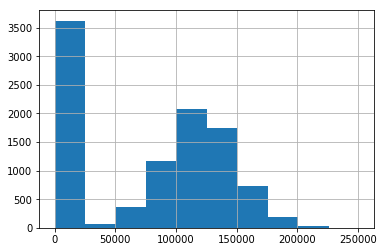

In [9]:
data['Balance'].hist()

> In most columns the values doesn't change too much with or wothout balance=0, in the most interesting one - 'Exit' the gap in means is less than 0.2*std. From the histogram it seems that it is not part of the distribution, hence, to replace it by average can be a good solution. 

## Data Preprocessing

In [10]:
avg = data[data['Balance']==0]['Balance'].mean() #finding the average balance excluding the 0 values
data['Balance'] = data['Balance'].apply(lambda x: avg if x==0 else x) # replacing the 0 with the average

In [11]:
data = data.drop(['RowNumber', 'CustomerId', 'Surname'] , axis=1) #these columns don't add any useful information

In [12]:
data = pd.get_dummies(data, drop_first=True) #converting the categorical features to dummies, for regression

In [13]:
data.dropna(inplace=True) #there are so few of them, better to delete

In [14]:
#splitting the data set to trainning, validation and (final) test sets. Target-who exited.
target = data['Exited']
features = data.drop(['Exited'] , axis=1)

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state=12345)

## Modeling

In [15]:
#running a simple model - Logistic Regression to see what's going on.
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_train, target_train)
predictions = model.predict(features_valid)

#Checking the accuracy score (successes out of predictions) and also the F1 score (harmonic mean of precision and recall)
print('accurancy score' , model.score(features_valid, target_valid))
print('F1 score', f1_score(target_valid, predictions))

accurancy score 0.8053875755909841
F1 score 0.078125


> The accuracy score is pretty high, but the F1 is very low! F1 is based on the number of True-Positive, an imbalance in the target of the dataset can cause it.

In [16]:
target.mean() #the presentage of positive targets

0.2039379606203938

> there are 4 times more 0s than 1s.

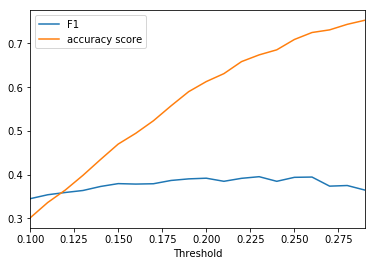

In [17]:
# The default threshold of the probabilty is 0.5, in this case brobably it is different.
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid) #probablity of the predictions
probabilities_one_valid = probabilities_valid[:, 1]

tres = [['Threshold', 'F1', 'accuracy score']] #a table with different thresholds and their scores
for threshold in np.arange(0.1, 0.3, 0.01):
    predicted_valid = probabilities_one_valid > threshold #predictions are 1 when the probability is over the threshold
    tres.append([threshold, f1_score(target_valid, predicted_valid), accuracy_score(target_valid, predicted_valid)]) #calculate the scores for the new predictions
    
pd.DataFrame(data=tres[1:], columns=tres[0]).set_index('Threshold').plot() #Scores over thresholds

In [18]:
pd.DataFrame(data=tres[1:], columns=tres[0]).set_index('Threshold').sort_values(by='F1', ascending=False).head() #thresholds sorted by F1 scores

,F1,accuracy score
Threshold,,
0.23,0.395515,0.673997
0.26,0.394673,0.725124
0.25,0.394044,0.709181
0.20,0.392055,0.612974
0.22,0.391773,0.658604


> The best F1 is for threshhold 0.23, much better than it was with 0.5 threshold. But not high enough.

AUC ROC = 0.68


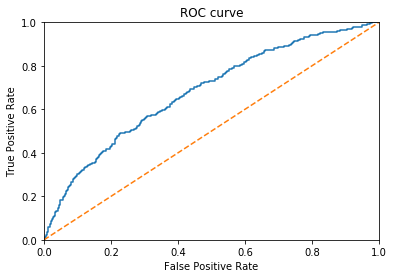

In [19]:
#AUC ROC and the ROC curve:
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('AUC ROC = {:.2f}'.format(auc_roc))

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) #plotting the ROC curve, with the random line
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--') #demstrate random predictions
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

> The AUC is higher than random (0.5) and the ROC curve is higher than the random line, but both are not very high.

In [20]:
#Another technique: Upsampling the positive samples for balancing:
def upsample(features, target, repeat): #upsampling function for 1s
    #splitting the data to 0 and 1:
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    #multiply the 1s and concatenate
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345) #adding randomization by shuffling
    
    return features_upsampled, target_upsampled

In [21]:
#upsample the trainning set. and checking the new balance
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)
target_upsampled.mean()

0.509963768115942

> Now we are balanced

In [22]:
#Training the balanced dataset
model = LogisticRegression(solver='liblinear', random_state=12345)
model.fit(features_upsampled, target_upsampled)

print('accuracy score', model.score(features_valid, target_valid))
print('F1 score', f1_score(target_valid, model.predict(features_valid)))

accuracy score 0.6470588235294118
F1 score 0.42678571428571427


> Although the accuracy score is lower, the F1 is much higher.

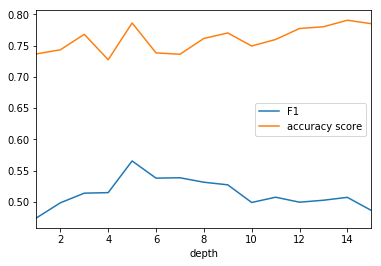

In [23]:
#Another model - Decision Tree
DTC = [['depth','F1','accuracy score']] 
for depth in range(1, 16, 1): #Hyperparameters tuning
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    DTC.append([depth, f1_score(target_valid, model.predict(features_valid)), model.score(features_valid, target_valid)])

DTC_df = pd.DataFrame(data=DTC[1:], columns=DTC[0]).set_index('depth')
DTC_df.plot() #scores over depth

In [24]:
DTC_df.sort_values(by='F1', ascending=False).head() #depth sorted by F1 score.

,F1,accuracy score
depth,,
5,0.565363,0.786146
7,0.538462,0.736119
6,0.537864,0.738318
8,0.531317,0.761407
9,0.527149,0.770203


> In DecisionTreeClassifier with depth = 5 we got better results than before.

In [25]:
#Another, stronger model - Random Forest
RFC = [['n estimators', 'max depth', 'F1', 'accuracy score']]
for estim in range(10, 51, 5): #Hyperparameters tuning
    for depth in range(1, 16, 1):
        model = RandomForestClassifier(n_estimators=estim, max_depth=depth, random_state=12345)
        model.fit(features_upsampled, target_upsampled)
        RFC.append([estim, depth, f1_score(target_valid, model.predict(features_valid)), model.score(features_valid, target_valid)]) 

RFC_df = pd.DataFrame(data=RFC[1:], columns=RFC[0]).sort_values(by='F1', ascending=False).reset_index()  #Results sorted by F1 score.
RFC_df.head()

,index,n estimators,max depth,F1,accuracy score
0,134,50,15,0.615385,0.854316
1,88,35,14,0.613636,0.850467
2,103,40,14,0.610795,0.849368
3,104,40,15,0.608696,0.851567
4,73,30,14,0.608204,0.847719


In [26]:
RFC_df['n estimators'][0]

50

> Nice improvement in results! we should use random forest with the best hyperparameters for avaluate the final test.

AUC ROC = 0.85


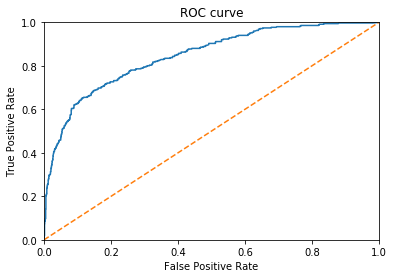

In [27]:
#AUC ROC and the ROC curve with the upsamples random forest:
model = RandomForestClassifier(n_estimators=RFC_df['n estimators'][0], max_depth=RFC_df['max depth'][0], random_state=12345)
model.fit(features_upsampled, target_upsampled)

probabilities_valid = model.predict_proba(features_valid) #probablity of the predictions
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(target_valid, probabilities_one_valid) # Area under the ROC curve
print('AUC ROC = {:.2f}'.format(auc_roc))

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid) #plotting the ROC curve, with the random line
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

> This is a great result!

## Final Test

In [28]:
#Now let's train the model on the training and validation sets for the final test:
#First we need the imbalance of the validation set
target_valid.mean()

0.19296316657504123

In [29]:
features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, 4) #upsampling
features_upsampled_valid, target_upsampled_valid = upsample(features_valid, target_valid, 3)
features_final = pd.concat([features_upsampled_train] + [features_upsampled_valid])
target_final = pd.concat([target_upsampled_train] + [target_upsampled_valid])

#training the whole training set with the best model.
model = RandomForestClassifier(n_estimators=RFC_df['n estimators'][0], max_depth=RFC_df['max depth'][0], random_state=12345)
model.fit(features_final, target_final)
print('accuracy score = {:.2f} | F1 score = {:.2f}'.format(model.score(features_test, target_test), 
                                                           f1_score(target_test, model.predict(features_test))))

accuracy score = 0.85 | F1 score = 0.62


> Finally we got good results, the bank can use this model for prediction customer that whish to leave and offer them special programs.